In [1]:
!pip install gradio tensorflow scikit-learn numpy pandas matplotlib joblib


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import joblib
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks


In [3]:
from google.colab import files
uploaded = files.upload()   # upload diabetes.csv


Saving diabetes.csv to diabetes.csv


In [4]:
df = pd.read_csv("diabetes.csv")
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# Replace zeros with NaN for specific medical columns
cols_with_zeros = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)

# Impute missing values with median
df.fillna(df.median(), inplace=True)

# Separate X and y
X = df.drop('Outcome', axis=1).values
y = df['Outcome'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Save scaler
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [6]:
def build_model(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.15),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

model = build_model(X_train.shape[1])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
es = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=12,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=200,
    batch_size=32,
    callbacks=[es],
    verbose=2
)


Epoch 1/200
17/17 - 4s - 239ms/step - accuracy: 0.5278 - loss: 0.7107 - val_accuracy: 0.7419 - val_loss: 0.5992
Epoch 2/200
17/17 - 0s - 28ms/step - accuracy: 0.7063 - loss: 0.6098 - val_accuracy: 0.7527 - val_loss: 0.5397
Epoch 3/200
17/17 - 1s - 36ms/step - accuracy: 0.7217 - loss: 0.5655 - val_accuracy: 0.7742 - val_loss: 0.5021
Epoch 4/200
17/17 - 0s - 28ms/step - accuracy: 0.7543 - loss: 0.5139 - val_accuracy: 0.7742 - val_loss: 0.4742
Epoch 5/200
17/17 - 0s - 28ms/step - accuracy: 0.7620 - loss: 0.4989 - val_accuracy: 0.7742 - val_loss: 0.4577
Epoch 6/200
17/17 - 0s - 19ms/step - accuracy: 0.7678 - loss: 0.4902 - val_accuracy: 0.7849 - val_loss: 0.4472
Epoch 7/200
17/17 - 0s - 27ms/step - accuracy: 0.7543 - loss: 0.4932 - val_accuracy: 0.7957 - val_loss: 0.4392
Epoch 8/200
17/17 - 0s - 26ms/step - accuracy: 0.7697 - loss: 0.4633 - val_accuracy: 0.7957 - val_loss: 0.4299
Epoch 9/200
17/17 - 0s - 17ms/step - accuracy: 0.7793 - loss: 0.4531 - val_accuracy: 0.8065 - val_loss: 0.4252


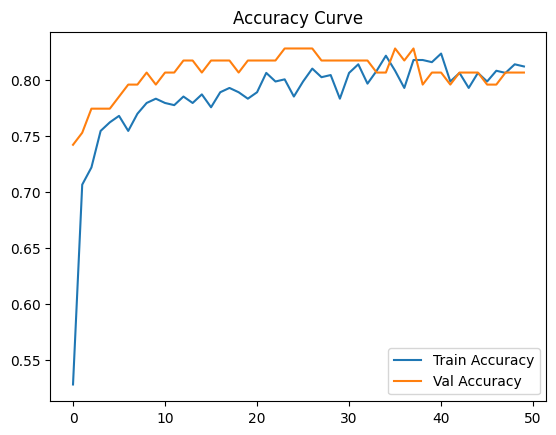

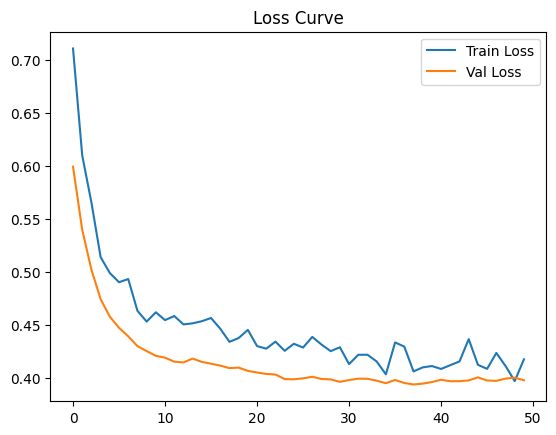

In [8]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy Curve")
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()


In [9]:
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       100
           1       0.64      0.56      0.59        54

    accuracy                           0.73       154
   macro avg       0.71      0.69      0.70       154
weighted avg       0.73      0.73      0.73       154

Confusion Matrix:
[[83 17]
 [24 30]]
ROC AUC Score: 0.8125925925925925


In [10]:
model.save("diabetes_ann_model.h5")
print("Model saved successfully.")


Model saved successfully.


In [11]:
import gradio as gr

def predict_diabetes(Pregnancies, Glucose, BloodPressure, SkinThickness,
                     Insulin, BMI, DiabetesPedigreeFunction, Age):

    x = np.array([[Pregnancies, Glucose, BloodPressure, SkinThickness,
                   Insulin, BMI, DiabetesPedigreeFunction, Age]])

    scaler = joblib.load('scaler.pkl')
    x = scaler.transform(x)

    model = tf.keras.models.load_model("diabetes_ann_model.h5")
    prob = model.predict(x)[0][0]

    if prob >= 0.5:
        result = "🔴 High Risk of Diabetes"
    else:
        result = "🟢 Low Risk of Diabetes"

    return f"{result} (Probability: {prob:.2f})"


inputs = [
    gr.Number(label="Pregnancies"),
    gr.Number(label="Glucose"),
    gr.Number(label="BloodPressure"),
    gr.Number(label="SkinThickness"),
    gr.Number(label="Insulin"),
    gr.Number(label="BMI"),
    gr.Number(label="DiabetesPedigreeFunction"),
    gr.Number(label="Age"),
]

interface = gr.Interface(
    fn=predict_diabetes,
    inputs=inputs,
    outputs="text",
    title="Diabetes Prediction using ANN",
    description="Enter patient data to predict the risk of diabetes."
)

interface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c9c07df3d1c991ad1a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
